<a href="https://colab.research.google.com/github/SuddenWind/emotions_recognition/blob/main/Face_emotions_coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
# import torch
import time

from google.colab.patches import cv2_imshow
import os, sys
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LayerNormalization, Input, Normalization
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D, add
from keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
# from keras.regularizers import l2
from keras.utils import np_utils

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
!apt install cadaver
# get skill/pp_train.zip

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16/view?usp=sharing
!gdown --fuzzy https://drive.google.com/file/d/12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K/view?usp=sharing

In [ ]:
!nvidia-smi

Sun May 21 19:48:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Изучаю dataset

In [ ]:
!unzip train.zip
!unzip test_kaggle.zip

In [ ]:
file_list = glob.glob('/content/train/*/*', recursive=False)
[f for f in file_list if f[-3:] != 'jpg'] # тут только jpg

[]

In [ ]:
file_list = glob.glob('/content/test_kaggle/*', recursive=False)
[f for f in file_list if f[-3:] != 'jpg'] # тут только jpg

[]

In [ ]:
os.mkdir('pp_train/')
dir_list = glob.glob('/content/train/*', recursive=False)
dir_list = [os.path.basename(dir) for dir in dir_list]
for dir in dir_list:
  os.mkdir('pp_train/'+dir)

In [ ]:
for f in file_list[:20]:      # разрешения разные
  img = cv.imread(f)
  print(img.shape)

(810, 810, 3)
(1047, 1047, 3)
(185, 185, 3)
(338, 338, 3)
(1061, 1061, 3)
(205, 205, 3)
(189, 189, 3)
(228, 228, 3)
(279, 279, 3)
(222, 222, 3)
(1314, 1314, 3)
(349, 349, 3)
(836, 836, 3)
(192, 192, 3)
(367, 367, 3)
(759, 759, 3)
(825, 825, 3)
(285, 285, 3)
(175, 175, 3)
(1486, 1486, 3)


## csv - подготовка меток

In [ ]:
df = pd.read_csv('train.csv', usecols=[1,2])
df['emotion'] = df['emotion'].astype('category')
df['code'] = df['emotion'].cat.codes
df = df.set_index('image_path')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
df

emotion  code
image_path                                
./train/anger/0.jpg            anger     0
./train/anger/1.jpg            anger     0
./train/anger/10.jpg           anger     0
./train/anger/100.jpg          anger     0
./train/anger/1000.jpg         anger     0
...                              ...   ...
./train/uncertain/995.jpg  uncertain     8
./train/uncertain/996.jpg  uncertain     8
./train/uncertain/997.jpg  uncertain     8
./train/uncertain/998.jpg  uncertain     8
./train/uncertain/999.jpg  uncertain     8

[50046 rows x 2 columns]

In [ ]:
df.groupby('emotion').count()

code
emotion        
anger      7022
contempt   3085
disgust    3155
fear       5044
happy      5955
neutral    6795
sad        6740
surprise   6323
uncertain  5927

достаточно сбалансированный по классам ДС

In [ ]:
emotion_dict = dict(enumerate(df['emotion'].cat.categories))
emotion_dict

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

In [ ]:
df.loc['./train/anger/0.jpg', 'code']

0

In [ ]:
sample_df = pd.read_csv('sample_submission.csv')
sample_df

image_path  emotion
0         0.jpg  neutral
1         1.jpg  neutral
2         2.jpg  neutral
3         3.jpg  neutral
4         4.jpg  neutral
...         ...      ...
4995   4995.jpg  neutral
4996   4996.jpg  neutral
4997   4997.jpg  neutral
4998   4998.jpg  neutral
4999   4999.jpg  neutral

[5000 rows x 2 columns]

# preprocessing

скачиваю необходимые библиотеки

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

In [ ]:
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!bzip2 -d mmod_human_face_detector.dat.bz2

In [ ]:
%cd /content

/content


In [ ]:
# !git clone https://github.com/Tanoy004/Emotion-recognition-through-CNN.git

In [ ]:
dlib.cuda.get_device()

0

In [ ]:
def autoAdjustments_with_convertScaleAbs(img, low, high):
  ''' выравнивание цвета по гистограмме '''
  alow =  np.quantile(img, low)
  ahigh = np.quantile(img, high)
  #print(f'low {low} max {high}')
  amax = 255
  amin = 0
  # calculate alpha, beta
  alpha = ((amax - amin) / (ahigh - alow))
  beta = amin - alow * alpha
  # perform the operation g(x,y)= α * f(x,y)+ β
  new_img = cv.convertScaleAbs(img, alpha=alpha, beta=beta)

  return new_img

In [ ]:
img = cv.imread('/content/train/anger/1010.jpg')
cv2_imshow(img)
img = autoAdjustments_with_convertScaleAbs(img, .005, .995)
cv2_imshow(img)

Выравниваю по расположение глаз и вырезаю лица

In [ ]:
from collections import OrderedDict


#For dlib’s 68-point facial landmark detector:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((shape.num_parts, 2), dtype=dtype)

	# loop over all facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, shape.num_parts):
		coords[i] = (shape.part(i).x, shape.part(i).y)

	# return the list of (x, y)-coordinates
	return coords

class FaceAligner:
	def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
		desiredFaceWidth=256, desiredFaceHeight=None):
		# store the facial landmark predictor, desired output left
		# eye position, and desired output face width + height
		self.predictor = predictor
		self.desiredLeftEye = desiredLeftEye
		self.desiredFaceWidth = desiredFaceWidth
		self.desiredFaceHeight = desiredFaceHeight

		# if the desired face height is None, set it to be the
		# desired face width (normal behavior)
		if self.desiredFaceHeight is None:
			self.desiredFaceHeight = self.desiredFaceWidth

	def align(self, image, gray, rect):
		# convert the landmark (x, y)-coordinates to a NumPy array
		shape = self.predictor(gray, rect)
		shape = shape_to_np(shape)

		#simple hack ;)
		if (len(shape)==68):
			# extract the left and right eye (x, y)-coordinates
			(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
			(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
		else:
			(lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
			(rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]

		leftEyePts = shape[lStart:lEnd]
		rightEyePts = shape[rStart:rEnd]

		# compute the center of mass for each eye
		leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
		rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

		# compute the angle between the eye centroids
		dY = rightEyeCenter[1] - leftEyeCenter[1]
		dX = rightEyeCenter[0] - leftEyeCenter[0]
		angle = np.degrees(np.arctan2(dY, dX)) - 180

		# compute the desired right eye x-coordinate based on the
		# desired x-coordinate of the left eye
		desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

		# determine the scale of the new resulting image by taking
		# the ratio of the distance between eyes in the *current*
		# image to the ratio of distance between eyes in the
		# *desired* image
		dist = np.sqrt((dX ** 2) + (dY ** 2))
		desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
		desiredDist *= self.desiredFaceWidth
		scale = desiredDist / dist

		# compute center (x, y)-coordinates (i.e., the median point)
		# between the two eyes in the input image
		eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2),
			int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))

		# grab the rotation matrix for rotating and scaling the face
		M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

		# update the translation component of the matrix
		tX = self.desiredFaceWidth * 0.5
		tY = self.desiredFaceHeight * self.desiredLeftEye[1]
		M[0, 2] += (tX - eyesCenter[0])
		M[1, 2] += (tY - eyesCenter[1])

		# apply the affine transformation
		(w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
		output = cv2.warpAffine(image, M, (w, h),
			flags=cv2.INTER_CUBIC)

		# return the aligned face
		return output

In [ ]:
from imutils.face_utils import rect_to_bb
from imutils import paths
import argparse
import imutils
import dlib
import cv2


IMG_SIZE = 224
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor and the face aligner
# detector = dlib.get_frontal_face_detector()
detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')
# fa = FaceAligner(predictor, desiredFaceWidth=256, desiredFaceHeight=256)
fa = FaceAligner(predictor, desiredFaceWidth=IMG_SIZE, desiredFaceHeight=IMG_SIZE)


print("Image pre-processing is starting. Aligning image according to facial landmarks.")
# loop over the input images
# for inputPath in paths.list_images(args["input"]): /content/train/anger/0.jpg
for inputPath in tqdm(file_list):
    # load the image, convert it to grayscale, and describe it
    image = cv2.imread(inputPath)
    image = autoAdjustments_with_convertScaleAbs(image, .005, .995)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    # rects = detector(gray, 2)
    results = detector(gray, 0)
    rects = [r.rect for r in results]


    # loop over the face detections
    for rect in rects:
        # extract the ROI of the *original* face, then align the face
        # using facial landmarks
        faceAligned = fa.align(image, gray, rect)

        # write the output image to disk
        path = 'pp_test'
        # path = os.path.join(path, inputPath.split("/")[-2], inputPath.split("/")[-1])
        path = os.path.join(path, inputPath.split("/")[-1])
        # print(path)
        if cv2.imwrite(path, faceAligned) == 0:
          print(inputPath)

        # display the output images
        # cv2_imshow(faceAligned)

print("\n Image face alignment is completed.")

# Reference:
# https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/

Image pre-processing is starting. Aligning image according to facial landmarks.


100%|██████████| 5000/5000 [06:43<00:00, 12.38it/s]


 Image face alignment is completed.


То же для test

In [ ]:
!zip -r pp_train.zip pp_train

In [ ]:
!zip -r pp_test224.zip pp_test/

# dataset

In [ ]:
!unzip pp_train.zip

In [ ]:
file_list = glob.glob('/content/pp_train/anger/*', recursive=False)
train_x = []

for f in tqdm(file_list):
  img = cv.imread(f, cv.IMREAD_COLOR)
  train_x.append(img)

train_x = np.array(train_x, 'float32')
train_x.shape

100%|██████████| 7002/7002 [00:09<00:00, 729.61it/s]


(7002, 256, 256, 3)

In [ ]:
sys.getsizeof(train_x) / 1000000    # 5.5 Gb/7000 imgs -> 47 Gb/60 000 imgs

5506.597024

Для хранения в float не хватит RAM, буду хранить в int

In [ ]:
def load_dataset(df):
  x, y = [], []
  err_list = []

  for fname, row in tqdm(df.iterrows(), total=len(df)):
    fname = 'pp_' + fname[2:]
    img = cv.imread(fname, cv.IMREAD_COLOR)
    if img is None:
      err_list.append(fname)
      continue

    if RESIZE:
      img = cv.resize(img, (SIZE, SIZE))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    x.append(img)
    y.append(row['code'])

  x = np.array(x, 'uint8')
  y = np.array(y, 'uint8')
  print(y.shape)
  print(x.shape)
  print(err_list)

  return x, y

RESIZE = False
SIZE = 128

train_x, train_y = load_dataset(train_df) #.iloc[:30000])
test_x, test_y = load_dataset(test_df.iloc[:5000])

100%|██████████| 40036/40036 [00:48<00:00, 818.80it/s]


(39906,)
(39906, 256, 256, 3)
['pp_train/neutral/3599.jpg', 'pp_train/fear/2961.jpg', 'pp_train/sad/6188.jpg', 'pp_train/contempt/508.jpg', 'pp_train/anger/3238.jpg', 'pp_train/anger/277.jpg', 'pp_train/neutral/1784.jpg', 'pp_train/uncertain/5748.jpg', 'pp_train/sad/3767.jpg', 'pp_train/happy/72.jpg', 'pp_train/surprise/5995.jpg', 'pp_train/fear/1835.jpg', 'pp_train/anger/5458.jpg', 'pp_train/fear/3498.jpg', 'pp_train/neutral/2511.jpg', 'pp_train/anger/1637.jpg', 'pp_train/happy/732.jpg', 'pp_train/uncertain/2580.jpg', 'pp_train/disgust/1486.jpg', 'pp_train/happy/1414.jpg', 'pp_train/contempt/2710.jpg', 'pp_train/fear/1774.jpg', 'pp_train/surprise/2205.jpg', 'pp_train/fear/4331.jpg', 'pp_train/uncertain/1754.jpg', 'pp_train/fear/151.jpg', 'pp_train/uncertain/5868.jpg', 'pp_train/uncertain/5898.jpg', 'pp_train/fear/2458.jpg', 'pp_train/uncertain/1509.jpg', 'pp_train/neutral/5394.jpg', 'pp_train/surprise/3771.jpg', 'pp_train/uncertain/4029.jpg', 'pp_train/sad/4698.jpg', 'pp_train/neutral

100%|██████████| 5000/5000 [00:05<00:00, 874.82it/s]


(4990,)
(4990, 256, 256, 3)
['pp_train/fear/1348.jpg', 'pp_train/surprise/4411.jpg', 'pp_train/uncertain/1163.jpg', 'pp_train/neutral/389.jpg', 'pp_train/uncertain/402.jpg', 'pp_train/sad/3795.jpg', 'pp_train/uncertain/1741.jpg', 'pp_train/surprise/2195.jpg', 'pp_train/anger/6158.jpg', 'pp_train/happy/4484.jpg']


In [ ]:
sys.getsizeof(train_x) / 1000000

7847.805088

In [ ]:
sys.getsizeof(train_x) / 1000000

1103.70832

In [ ]:
sys.getsizeof(train_y) / 1000

40.023

## tfrecord

Реализовал хранение в tfrecord, но потом не стал использовать, т.к. хранил в RAM

In [ ]:
import tensorflow as tf


def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):

  feature = {
      'image_raw': _bytes_feature(image_string),
      'label': _int64_feature(label)
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
#normalizing data
train_x -= np.mean(train_x, axis=0)
train_x /= np.std(train_x, axis=0)

In [ ]:
file_list = glob.glob('pp_train/anger/*', recursive=False)

In [ ]:
NORM = False

record_file = 'emotions.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename in tqdm(file_list):
    img = cv.imread(filename, cv.IMREAD_COLOR)
    img = np.array(img, 'uint8')      # float32

    #normalizing data
    if NORM:
      img -= np.mean(img)
      img /= np.std(img)

    fname = './' + filename[3:]
    try:
      label = df.loc[fname, 'code']
    except KeyError:
      print(filename)
      continue

    serialized_array = tf.io.serialize_tensor(img)
    tf_example = image_example(serialized_array, label)
    writer.write(tf_example.SerializeToString())

 19%|█▉        | 1334/7002 [00:09<00:31, 179.25it/s]

pp_train/anger/06666.jpg


100%|██████████| 7002/7002 [00:44<00:00, 155.83it/s]


In [ ]:
# Creates a dataset that reads all of the examples from two files.
# fsns_test_file = tf.keras.utils.get_file("emotions.tfrecord")
dataset = tf.data.TFRecordDataset(filenames = ["emotions.tfrecords"])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
feature = tf.io.parse_tensor(parsed.features.feature['image_raw'], out_type=tf.float32) # restore 2D array from byte string
feature

In [ ]:
keys_to_features = {'image_raw': tf.io.FixedLenFeature([], tf.string),
                        "label": tf.io.FixedLenFeature([], tf.int64)}

example_message = tf.io.parse_single_example(next(iter(dataset)), keys_to_features)

b_feature = example_message['image_raw'] # get byte string
feature = tf.io.parse_tensor(b_feature, out_type=tf.uint8) # restore 2D array from byte string float32
feature

In [ ]:
SHUFFLE_BUFFER = 1024
BATCH_SIZE = 254
AUTOTUNE = tf.data.AUTOTUNE

def _parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'image_raw': tf.io.FixedLenFeature([], tf.string),
                        "label": tf.io.FixedLenFeature([], tf.int64)}

    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    img = parsed_features['image_raw']
    img = tf.io.parse_tensor(img, out_type=tf.float32)

    label = parsed_features['label']

    return img, label

def prepare_sample(features):
    return features["T_vec"], features["Label"]

def create_dataset(filepath):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath)

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    #dataset = dataset.take(3)
    dataset = dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)

    # Set the number of datapoints you want to load and shuffle
    dataset = dataset.shuffle(SHUFFLE_BUFFER)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

# STEPS_PER_EPOCH= SUM_OF_ALL_DATASAMPLES / BATCHSIZE
#Get your datatensors
ds = create_dataset('emotions.tfrecords')

In [ ]:
# print('iter ', next(iter(ds)))
print('spec', ds.element_spec)

spec (TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


## Albumenatations

Использую несколько вариантов Albumenatations для улучшения результатов

In [ ]:
import tensorflow as tf
import albumentations as A
from functools import partial

In [ ]:
image = cv2.imread('images/image_3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

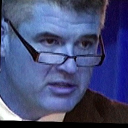

In [ ]:
img = train_x[2]
cv2_imshow(img)

In [ ]:
transform = A.Compose([
    A.CLAHE(),
    A.HueSaturationValue(),  # hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.10, rotate_limit=0, p=.75),
    A.Blur(blur_limit=3),
    # A.OpticalDistortion(),
    # A.GridDistortion(),
    A.HorizontalFlip()
])
# random.seed(42)
# augmented_image = transform(image=img)['image']
# cv2_imshow(augmented_image)

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(),
    A.OneOf([A.MotionBlur(p=1),
            A.OpticalDistortion(p=1),
            A.GaussNoise(p=1)

In [ ]:
train_transforms = A.Compose([
        A.HorizontalFlip(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=0.02, p=.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(num_steps=4, p=.1),
            #IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomContrast(),
            A.RandomBrightness(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        # ToTensor()
    ], p=1.0)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:778: FutureWarning: JpegCompression has been deprecated. Please use ImageCompression
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:176: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmen

In [ ]:
BATCH_SIZE = 128             # 128 model 2 / 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
# test_dataset = test_dataset.map(lambda x, y: (tf.cast(x/255, tf.float32), y)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
del train_x

In [ ]:
# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transform(**data)
#     aug_img = aug_data["image"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     # aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = train_transforms(**data)
    aug_img = aug_data["image"]
    # aug_img = tf.cast(aug_img, tf.float32)
    return aug_img

def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.uint8) # float32
    return aug_img, label

def set_shapes(img, label, img_shape=(128,128,3)):
    img.set_shape(img_shape)
    label.set_shape([])      # []
    return img, label

def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    # label = [emotion_dict[l] for l in label]

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

In [ ]:
BATCH_SIZE = 32

In [ ]:
# create dataset
ds_alb = train_dataset.map(partial(process_data, img_size=128),
                  num_parallel_calls=AUTOTUNE)#.prefetch(AUTOTUNE)
ds_alb = ds_alb.map(partial(set_shapes, img_shape = (128,128,3)),
                  num_parallel_calls=AUTOTUNE).shuffle(128).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_alb

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [ ]:
# create dataset
ds_alb = train_dataset.map(partial(process_data, img_size=256),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb = ds_alb.map(partial(set_shapes, img_shape = (256,256,3)),
                  num_parallel_calls=AUTOTUNE).shuffle(128).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_alb

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [ ]:
next(iter(test_dataset))

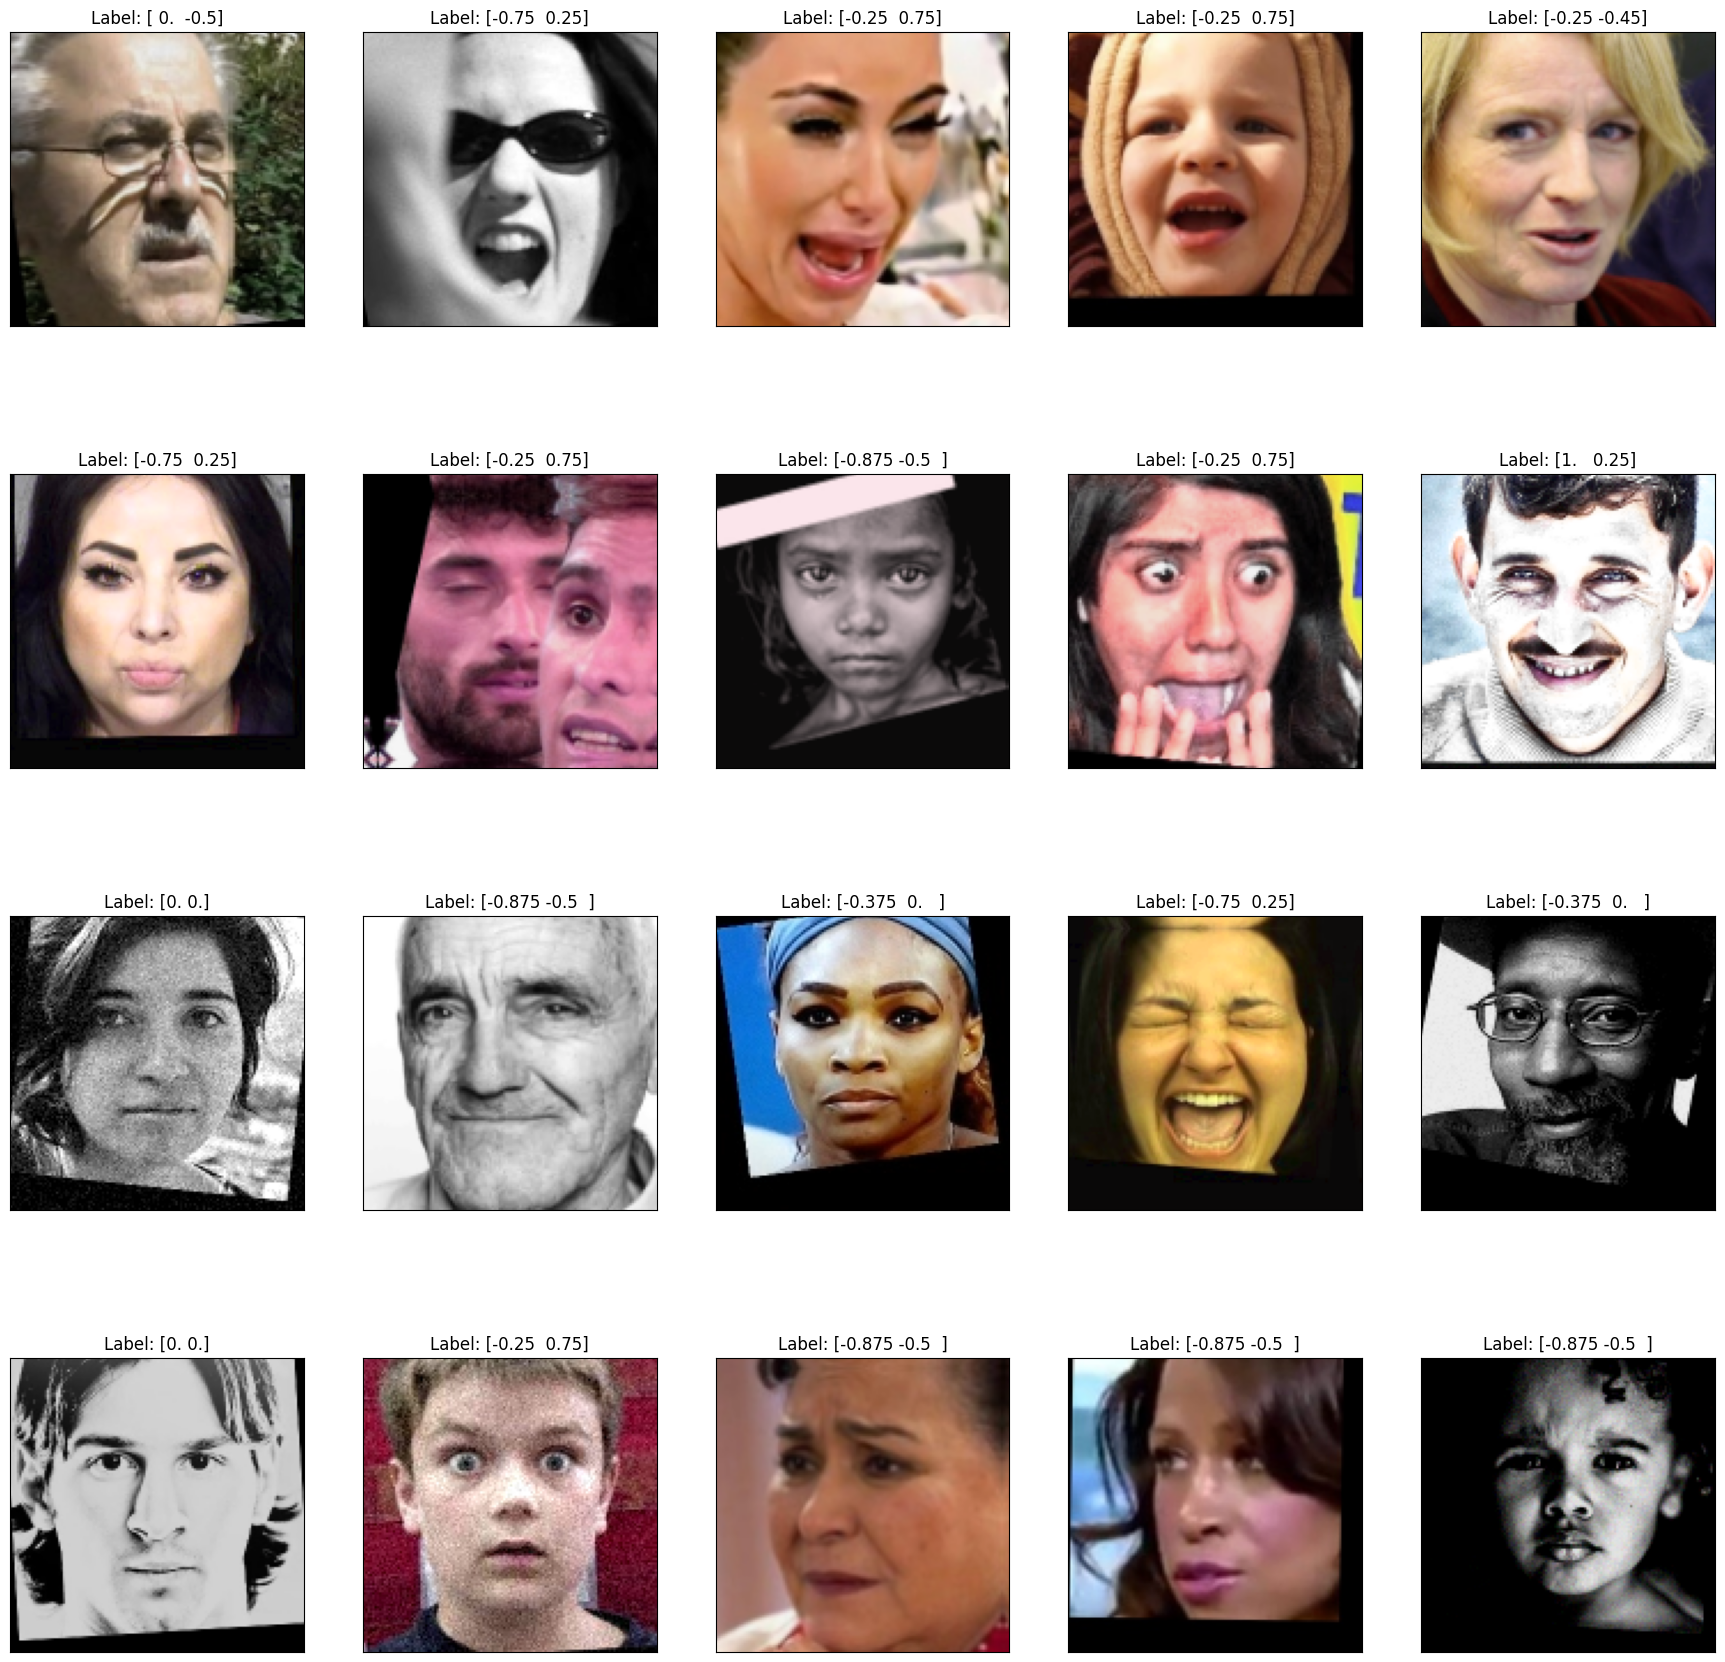

In [ ]:
view_image(ds_alb)

## Files test / train split

Test / train split for YOLO


In [ ]:
import random

rnd = random.Random(42)
output_path = 'val'
os.mkdir(output_path)
pathlist = glob.glob('pp_train/*')

for path_name in pathlist:
  path_name = os.path.basename(path_name)
  path_name = os.path.join(output_path, path_name)
  if not os.path.exists(path_name):
    os.makedirs(path_name)

filelist  = glob.glob('pp_train/*/*')
test = rnd.sample(filelist, int(len(filelist)*0.1))

for fname in tqdm(test):
    impath = fname
    out_image_fname = fname.split("/")[-2:]
    out_image_fname = out_image_fname[0] + '/' + out_image_fname[1]
    out_image_fname = os.path.join(output_path, out_image_fname)

    # print(impath,out_image_fname)
    os.system('mv ' + impath + ' ' + out_image_fname)

100%|██████████| 4989/4989 [00:08<00:00, 590.23it/s]


## VA convert

Подготовка лейблов для обучения модели VA

https://github.com/kigors/emotion_detection_experiments/blob/master/Valence-arousal%20model.ipynb<br>
https://www.mdpi.com/2076-3417/11/3/1338/htm

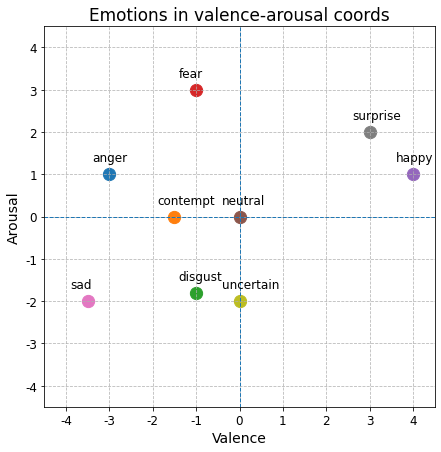

In [ ]:
# fisrt number - valence, second - arousal
VA_domains = {
    'anger':    [  -3,   1],
    'contempt': [-1.5,   0],
    'disgust':  [  -1,-1.8],
    'fear':     [  -1,   3],
    'happy':    [   4,   1],
    'neutral':  [   0,   0],
    'sad':      [-3.5,  -2],
    'surprise': [   3,   2],
    'uncertain':[   0,  -2]
}

In [ ]:
VA_df = pd.DataFrame(VA_domains).T / 4    # norm
VA_df.columns = ['valence','arousal']
VA_df

valence  arousal
anger       -0.750     0.25
contempt    -0.375     0.00
disgust     -0.250    -0.45
fear        -0.250     0.75
happy        1.000     0.25
neutral      0.000     0.00
sad         -0.875    -0.50
surprise     0.750     0.50
uncertain    0.000    -0.50

In [ ]:
df['valence'] = df['emotion'].map(VA_df['valence'])
df['arousal'] = df['emotion'].map(VA_df['arousal'])
df

emotion  code  valence  arousal
image_path                                                  
./train/anger/0.jpg            anger     0    -0.75     0.25
./train/anger/1.jpg            anger     0    -0.75     0.25
./train/anger/10.jpg           anger     0    -0.75     0.25
./train/anger/100.jpg          anger     0    -0.75     0.25
./train/anger/1000.jpg         anger     0    -0.75     0.25
...                              ...   ...      ...      ...
./train/uncertain/995.jpg  uncertain     8     0.00    -0.50
./train/uncertain/996.jpg  uncertain     8     0.00    -0.50
./train/uncertain/997.jpg  uncertain     8     0.00    -0.50
./train/uncertain/998.jpg  uncertain     8     0.00    -0.50
./train/uncertain/999.jpg  uncertain     8     0.00    -0.50

[50046 rows x 4 columns]

In [ ]:
df.info()

In [ ]:
type(df.iloc[0][['valence','arousal']].values[0])

numpy.float64

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# architecture search

Некоторые из экспериментов с подбором вручныю написанных архитектур. Больше - в черновике

## CNN 2

In [ ]:
# Initialising the CNN
model = Sequential()
# 1 - Convolution
# model.add(LayerNormalization(axis=0)) #, input_shape=(128, 128, 3)))

model.add(Conv2D(64,(3,3), padding='same', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 5th Convolution layer
model.add(Conv2D(1024,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer 1st layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(9, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       2

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
#                              save_weights_only=True, mode='max', verbose=1)
callbacks = [reduce_lr]
history = model.fit(
    train_x, train_y,
    epochs=20, shuffle = True, batch_size = 256,
    validation_data=(test_x, test_y),
    callbacks=callbacks
)

Epoch 1/20
156/156 [==============================] - 178s 1s/step - loss: 2.2360 - accuracy: 0.1849 - val_loss: 2.0284 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 2/20
156/156 [==============================] - 135s 863ms/step - loss: 1.8607 - accuracy: 0.3269 - val_loss: 1.9036 - val_accuracy: 0.3015 - lr: 0.0010
Epoch 3/20
156/156 [==============================] - 135s 866ms/step - loss: 1.6576 - accuracy: 0.4035 - val_loss: 1.7790 - val_accuracy: 0.3515 - lr: 0.0010
Epoch 4/20
156/156 [==============================] - 135s 865ms/step - loss: 1.5363 - accuracy: 0.4442 - val_loss: 1.5962 - val_accuracy: 0.4149 - lr: 0.0010
Epoch 5/20
156/156 [==============================] - 135s 866ms/step - loss: 1.4501 - accuracy: 0.4732 - val_loss: 1.4942 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 6/20
156/156 [==============================] - 135s 867ms/step - loss: 1.3790 - accuracy: 0.4952 - val_loss: 1.4613 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 7/20
156/156 [=============================

In [ ]:
opt = Adam(lr=0.0001)
history = model.fit(
    train_x, train_y,
    epochs=25, shuffle = True, batch_size = 128+256,
    validation_data=(test_x, test_y),
    callbacks=callbacks
)

Epoch 1/25
104/104 [==============================] - 99s 826ms/step - loss: 0.7598 - accuracy: 0.7288 - val_loss: 1.4845 - val_accuracy: 0.5033 - lr: 1.0000e-05
Epoch 2/25
104/104 [==============================] - 67s 647ms/step - loss: 0.7642 - accuracy: 0.7253 - val_loss: 1.4858 - val_accuracy: 0.5036 - lr: 1.0000e-05
Epoch 3/25
104/104 [==============================] - 69s 661ms/step - loss: 0.7617 - accuracy: 0.7281 - val_loss: 1.4868 - val_accuracy: 0.5039 - lr: 1.0000e-05
Epoch 4/25
104/104 [==============================] - 67s 646ms/step - loss: 0.7571 - accuracy: 0.7287 - val_loss: 1.4891 - val_accuracy: 0.5032 - lr: 1.0000e-05
Epoch 5/25
104/104 [==============================] - 67s 645ms/step - loss: 0.7544 - accuracy: 0.7316 - val_loss: 1.4903 - val_accuracy: 0.5031 - lr: 1.0000e-05
Epoch 6/25
104/104 [==============================] - 67s 646ms/step - loss: 0.7519 - accuracy: 0.7287 - val_loss: 1.4905 - val_accuracy: 0.5027 - lr: 1.0000e-05
Epoch 7/25
104/104 [========

KeyboardInterrupt: ignored

49%

### +Albumenatations

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [reduce_lr, checkpoint]
history = model.fit(
    ds_alb,
    epochs=25,
    validation_data=(test_dataset),
    callbacks=callbacks
)

Epoch 1/25
312/312 [==============================] - ETA: 0s - loss: 2.2769 - accuracy: 0.1599
Epoch 1: saving model to model_weights.h5
312/312 [==============================] - 228s 586ms/step - loss: 2.2769 - accuracy: 0.1599 - val_loss: 2.1315 - val_accuracy: 0.1780 - lr: 0.0010
Epoch 2/25
312/312 [==============================] - ETA: 0s - loss: 1.9685 - accuracy: 0.2800
Epoch 2: saving model to model_weights.h5
312/312 [==============================] - 194s 546ms/step - loss: 1.9685 - accuracy: 0.2800 - val_loss: 1.7782 - val_accuracy: 0.3447 - lr: 0.0010
Epoch 3/25
312/312 [==============================] - ETA: 0s - loss: 1.7449 - accuracy: 0.3635
Epoch 3: saving model to model_weights.h5
312/312 [==============================] - 194s 547ms/step - loss: 1.7449 - accuracy: 0.3635 - val_loss: 1.6570 - val_accuracy: 0.3896 - lr: 0.0010
Epoch 4/25
312/312 [==============================] - ETA: 0s - loss: 1.6261 - accuracy: 0.4025
Epoch 4: saving model to model_weights.h5
312/

In [ ]:
opt = Adam(learning_rate=1e-5)
history = model.fit(
    ds_alb,
    epochs=15,
    validation_data=(test_dataset),
    callbacks=callbacks)

Epoch 1/15
312/312 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.5340
Epoch 1: saving model to model_weights.h5
312/312 [==============================] - 220s 593ms/step - loss: 1.3033 - accuracy: 0.5340 - val_loss: 1.2880 - val_accuracy: 0.5400 - lr: 1.0000e-05
Epoch 2/15
312/312 [==============================] - ETA: 0s - loss: 1.2899 - accuracy: 0.5353
Epoch 2: saving model to model_weights.h5
312/312 [==============================] - 219s 592ms/step - loss: 1.2899 - accuracy: 0.5353 - val_loss: 1.2857 - val_accuracy: 0.5423 - lr: 1.0000e-05
Epoch 3/15
312/312 [==============================] - ETA: 0s - loss: 1.2929 - accuracy: 0.5321
Epoch 3: saving model to model_weights.h5
312/312 [==============================] - 219s 591ms/step - loss: 1.2929 - accuracy: 0.5321 - val_loss: 1.2827 - val_accuracy: 0.5427 - lr: 1.0000e-05
Epoch 4/15
146/312 [=============>................] - ETA: 1:51 - loss: 1.2766 - accuracy: 0.5334

In [ ]:
model.evaluate(test_dataset)

78/78 [==============================] - 8s 96ms/step - loss: 1.2706 - accuracy: 0.5419


[1.2705787420272827, 0.5419212579727173]

/var/colab/app.log

### sample для Kaggle

In [ ]:
from keras.models import load_model

In [ ]:
BATCH_SIZE = 1
sample_dataset = tf.data.Dataset.from_tensor_slices((sample_x))
sample_dataset = sample_dataset.map(lambda x: (tf.cast(x/255, tf.float32))).batch(BATCH_SIZE)

In [ ]:
%cd ..

/content


In [ ]:
model.load_weights("model_weights.h5")

In [ ]:
results = model.predict(sample_dataset)

4988/4988 [==============================] - 17s 3ms/step


In [ ]:
results[0]

array([5.5980682e-02, 6.6232699e-04, 3.8855791e-03, 5.5672187e-02,
       5.5761157e-05, 8.7351538e-03, 8.3812302e-01, 2.5120007e-03,
       3.4373257e-02], dtype=float32)

In [ ]:
import pickle
with open('results_fnames.pkl', mode = 'wb') as f:
  pickle.dump(results, f)
  pickle.dump(sample_fnames, f)

In [ ]:
import pickle
with open('results_fnames.pkl', mode = 'wb') as f:
  pickle.dump(results, f)
  pickle.dump(sample_fnames, f)

In [ ]:
import pickle
with open('results_fnames.pkl', mode = 'rb') as f:
  results = pickle.load(f)
  sample_fnames = pickle.load(f)

results

array([[5.59806824e-02, 6.62326987e-04, 3.88557906e-03, ...,
        8.38123024e-01, 2.51200073e-03, 3.43732573e-02],
       [1.08514383e-01, 1.20470161e-03, 2.24824641e-02, ...,
        2.17469614e-02, 1.87366068e-01, 4.24275137e-02],
       [1.10012665e-03, 3.22148786e-04, 8.14355444e-04, ...,
        8.65920126e-01, 4.16163169e-03, 2.20551901e-02],
       ...,
       [7.58567676e-02, 1.23979775e-02, 2.32020020e-02, ...,
        6.46717623e-02, 2.85300255e-01, 1.05568796e-01],
       [8.89915507e-03, 3.10728472e-04, 4.42937529e-03, ...,
        5.66776812e-01, 2.38552764e-02, 6.70879483e-02],
       [1.41747752e-02, 4.38885719e-01, 9.85326897e-03, ...,
        3.53861158e-03, 1.52754853e-03, 1.47506753e-02]], dtype=float32)

In [ ]:
results = np.argmax(results, axis=1)
results

array([6, 5, 6, ..., 5, 6, 1])

In [ ]:
results = dict(zip(sample_fnames, results))

In [ ]:
emotion_dict = {0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

In [ ]:
sample_df['emotion'] = sample_df['image_path'].map(results)
sample_df['emotion'] = sample_df['emotion'].fillna(5)
sample_df['emotion'] = sample_df['emotion'].map(emotion_dict)
sample_df

image_path   emotion
0         0.jpg       sad
1         1.jpg   neutral
2         2.jpg       sad
3         3.jpg   disgust
4         4.jpg  contempt
...         ...       ...
4995   4995.jpg  surprise
4996   4996.jpg     anger
4997   4997.jpg   neutral
4998   4998.jpg       sad
4999   4999.jpg  contempt

[5000 rows x 2 columns]

In [ ]:
sample_df.to_csv('symbm.csv', index=None)

### model 2.2

In [ ]:
normalization_layer = Normalization(mean=105.5, variance=6227, axis=None)
# normalization_layer.adapt(train_x)

In [ ]:
def conv_batch_relu(x, n_filters):
  x = Conv2D(n_filters,(3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x


# Initialising the CNN
inputs = Input(shape=(128, 128, 3), name="img")
x = normalization_layer(inputs)
# 1 - Convolution
x = conv_batch_relu(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 2nd Convolution layer
x = conv_batch_relu(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 3rd Convolution layer
x = conv_batch_relu(x, 512)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 4th Convolution layer
x = conv_batch_relu(x, 512)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 5th Convolution layer
x = conv_batch_relu(x, 1024)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# Flattening
x = Flatten()(x)
# Fully connected layer 1st layer
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
# Fully connected layer 2nd layer
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
out = Dense(9, activation='softmax')(x)

opt = Adam(learning_rate=0.001)
model = Model(inputs, out)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 normalization (Normalizatio  (None, 128, 128, 3)      0         
 n)                                                              
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_32 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 64)       0   

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-5, mode='auto')

callbacks = [reduce_lr,]
history = model.fit(
    ds_alb,
    epochs=50,
    validation_data=(test_dataset),
    callbacks=callbacks
)

Epoch 1/50
312/312 [==============================] - 55s 171ms/step - loss: 2.2431 - accuracy: 0.1730 - val_loss: 2.0688 - val_accuracy: 0.2238 - lr: 0.0010
Epoch 2/50
312/312 [==============================] - 52s 167ms/step - loss: 1.8964 - accuracy: 0.3154 - val_loss: 1.7009 - val_accuracy: 0.3725 - lr: 0.0010
Epoch 3/50
312/312 [==============================] - 53s 170ms/step - loss: 1.6978 - accuracy: 0.3849 - val_loss: 1.5698 - val_accuracy: 0.4316 - lr: 0.0010
Epoch 4/50
312/312 [==============================] - 53s 168ms/step - loss: 1.5924 - accuracy: 0.4226 - val_loss: 1.5568 - val_accuracy: 0.4376 - lr: 0.0010
Epoch 5/50
312/312 [==============================] - 53s 170ms/step - loss: 1.5300 - accuracy: 0.4412 - val_loss: 1.4611 - val_accuracy: 0.4612 - lr: 0.0010
Epoch 6/50
312/312 [==============================] - 53s 169ms/step - loss: 1.4793 - accuracy: 0.4614 - val_loss: 1.4461 - val_accuracy: 0.4812 - lr: 0.0010
Epoch 7/50
312/312 [==============================] 

KeyboardInterrupt: ignored

### model 2 256px

In [ ]:
def conv_batch_relu(x, n_filters):
  x = Conv2D(n_filters,(3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

normalization_layer = Normalization(mean=105.5, variance=6227, axis=None)
# Initialising the CNN
inputs = Input(shape=(256, 256, 3), name="img")
x = normalization_layer(inputs)
# 0 - Convolution
x = conv_batch_relu(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 1 - Convolution
x = conv_batch_relu(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 2nd Convolution layer
x = conv_batch_relu(x, 256)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 3rd Convolution layer
x = conv_batch_relu(x, 512)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 4th Convolution layer
x = conv_batch_relu(x, 512)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# 5th Convolution layer
x = conv_batch_relu(x, 1024)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
# Flattening
x = Flatten()(x)
# Fully connected layer 1st layer
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
# Fully connected layer 2nd layer
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
out = Dense(9, activation='softmax')(x)

opt = Adam(learning_rate=0.001)
model = Model(inputs, out)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 256, 256, 3)]     0         
                                                                 
 normalization_3 (Normalizat  (None, 256, 256, 3)      0         
 ion)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_24 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 64)     0   

52.48

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001, mode='auto')

callbacks = [reduce_lr]
history = model.fit(
    ds_alb,
    epochs=30,
    validation_data=(test_dataset),
    callbacks=callbacks
)

Epoch 1/30
935/935 [==============================] - 410s 433ms/step - loss: 2.2981 - accuracy: 0.1435 - val_loss: 2.1358 - val_accuracy: 0.1718 - lr: 0.0010
Epoch 2/30
935/935 [==============================] - 396s 423ms/step - loss: 2.0291 - accuracy: 0.2493 - val_loss: 1.8134 - val_accuracy: 0.3366 - lr: 0.0010
Epoch 3/30
935/935 [==============================] - 397s 424ms/step - loss: 1.7744 - accuracy: 0.3514 - val_loss: 1.6495 - val_accuracy: 0.3988 - lr: 0.0010
Epoch 4/30
935/935 [==============================] - 398s 425ms/step - loss: 1.6444 - accuracy: 0.3991 - val_loss: 1.5811 - val_accuracy: 0.4362 - lr: 0.0010
Epoch 5/30
935/935 [==============================] - 399s 426ms/step - loss: 1.5690 - accuracy: 0.4228 - val_loss: 1.5578 - val_accuracy: 0.4349 - lr: 0.0010
Epoch 6/30
935/935 [==============================] - 398s 426ms/step - loss: 1.5160 - accuracy: 0.4448 - val_loss: 1.4853 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 7/30
935/935 [==========================

In [ ]:
os.mkdir('model')
model.save('model')

## A la ResNet

https://www.researchgate.net/publication/350421671_A_Classification_of_Arab_Ethnicity_Based_on_Face_Image_Using_Deep_Learning_Approach

In [ ]:
inputs = Input(shape=(32, 32, 3), name="img")
x = Conv2D(32, 3, activation="relu")(inputs)
x = Conv2D(64, 3, activation="relu")(x)
block_1_output = MaxPooling2D(3)(x)

x = Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = Conv2D(64, 3, activation="relu", padding="same")(x)

block_2_output = add([x, block_1_output])

x = Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = add([x, block_2_output])

x = Conv2D(64, 3, activation="relu")(block_3_output)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs, name="toy_resnet")
model.summary()

In [ ]:
# model.add(LayerNormalization(axis=1, input_shape=(48, 48, 3)))

inputs = Input(shape=(96, 96, 3), name="img")
x = Conv2D(128,(3,3), padding='same', input_shape=(96, 96, 3))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
block_1_output = Dropout(0.25)(x)
# 2nd Convolution layer
x = Conv2D(128,(5,5), padding='same')(block_1_output)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = add([x, block_1_output])
x = MaxPooling2D(pool_size=(2, 2))(x)
block_2_output = Dropout(0.25)(x)
# 3rd Convolution layer
x = Conv2D(512,(3,3), padding='same')(block_2_output)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = add([x, block_2_output])
x = MaxPooling2D(pool_size=(2, 2))(x)
block_3_output = Dropout(0.25)(x)
# 4th Convolution layer
x = Conv2D(512,(3,3), padding='same')(block_3_output)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = add([x, block_3_output])
x = MaxPooling2D(pool_size=(2, 2))(x)
block_4_output = Dropout(0.25)(x)

# x = Conv2D(1024,(6,6))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)

# Flattening
x = Flatten()(block_4_output)
# Fully connected layer 1st layer
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
# Fully connected layer 2nd layer
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
out = Dense(9, activation='softmax')(x)

opt = Adam(lr=0.001)
model = Model(inputs, out)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_30 (Conv2D)             (None, 96, 96, 128)  3584        ['img[0][0]']                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 96, 96, 128)  512        ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_40 (Activation)     (None, 96, 96, 128)  0           ['batch_normalization_40[0]

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

history = model.fit(
    train_x, train_y,
    epochs=25, shuffle = True, batch_size = 256,
    validation_data=(test_x, test_y),
    callbacks=[reduce_lr]
)

Epoch 1/25
156/156 [==============================] - 134s 731ms/step - loss: 2.1550 - accuracy: 0.2292 - val_loss: 1.9165 - val_accuracy: 0.2978 - lr: 0.0010
Epoch 2/25
156/156 [==============================] - 98s 628ms/step - loss: 1.7792 - accuracy: 0.3542 - val_loss: 1.7744 - val_accuracy: 0.3485 - lr: 0.0010
Epoch 3/25
156/156 [==============================] - 98s 628ms/step - loss: 1.6243 - accuracy: 0.4061 - val_loss: 1.7007 - val_accuracy: 0.3856 - lr: 0.0010
Epoch 4/25
156/156 [==============================] - 98s 628ms/step - loss: 1.5216 - accuracy: 0.4478 - val_loss: 1.6937 - val_accuracy: 0.3924 - lr: 0.0010
Epoch 5/25
156/156 [==============================] - 98s 628ms/step - loss: 1.4561 - accuracy: 0.4704 - val_loss: 1.6975 - val_accuracy: 0.3811 - lr: 0.0010
Epoch 6/25
156/156 [==============================] - 98s 628ms/step - loss: 1.3954 - accuracy: 0.4909 - val_loss: 1.5138 - val_accuracy: 0.4480 - lr: 0.0010
Epoch 7/25
156/156 [==============================]

## Inception

https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch

In [ ]:
from keras.initializers import glorot_uniform, Constant
from keras.layers import Input, MaxPool2D, GlobalAveragePooling2D, concatenate
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):

    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu',
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

kernel_init = glorot_uniform()
bias_init = Constant(value=0.2)
num_classes = 9

input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2',
           kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)

x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(num_classes, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(num_classes, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(num_classes, activation='softmax', name='output')(x)

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']           
 )                                                                                     

In [ ]:
import math

epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
              loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(train_x, [train_y, train_y, train_y],
                    validation_data=(test_x, [test_y, test_y, test_y]),
                    epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/25
117/117 [==============================] - 136s 922ms/step - loss: 3.5721 - output_loss: 2.2042 - auxilliary_output_1_loss: 2.3520 - auxilliary_output_2_loss: 2.2076 - output_accuracy: 0.1298 - auxilliary_output_1_accuracy: 0.1297 - auxilliary_output_2_accuracy: 0.1331 - val_loss: 3.4683 - val_output_loss: 2.1696 - val_auxilliary_output_1_loss: 2.1634 - val_auxilliary_output_2_loss: 2.1654 - val_output_accuracy: 0.1179 - val_auxilliary_output_1_accuracy: 0.1410 - val_auxilliary_output_2_accuracy: 0.1363 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/25
117/117 [==============================] - 95s 811ms/step - loss: 3.4705 - output_loss: 2.1704 - auxilliary_output_1_loss: 2.1658 - auxilliary_output_2_loss: 2.1678 - output_accuracy: 0.1349 - auxilliary_output_1_accuracy: 0.1350 - auxilliary_output_2_accuracy: 0.1342 - val_loss: 3.4598 - val_output_loss: 2.1624 - val_auxilliary

44%

In [ ]:
os.mkdir('model')
model.save('model')

In [ ]:
history = model.fit(train_x, [train_y, train_y, train_y],
                    validation_data=(test_x, [test_y, test_y, test_y]),
                    epochs=epochs, batch_size=256, callbacks=[lr_sc])

## BiT

https://huggingface.co/google/bit-50

In [ ]:
import tensorflow_hub as hub

https://storage.googleapis.com/bit_models/distill/R50x1_224.npz

In [ ]:
normalization_layer = Normalization(mean=105.5, variance=6227, axis=None)
model = tf.keras.Sequential([
            tf.keras.Input(shape=(256, 256, 3), name='input'),
            normalization_layer,
            hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1", trainable=True),
            tf.keras.layers.Dense(9, activation='softmax', name='output', kernel_initializer='zeros')
        ])
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 256, 256, 3)      0         
 n)                                                              
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 output (Dense)              (None, 9)                 18441     
                                                                 
Total params: 23,518,793
Trainable params: 23,518,793
Non-trainable params: 0
_________________________________________________________________


0.4657/ 0.5242

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-6, mode='auto')

history = model.fit(
    ds_alb, callbacks= [reduce_lr],
    epochs=30,
    validation_data=(test_dataset)
)

Epoch 1/30
1248/1248 [==============================] - 944s 744ms/step - loss: 2.1701 - accuracy: 0.1347 - val_loss: 2.1616 - val_accuracy: 0.1445 - lr: 0.0010
Epoch 2/30
1248/1248 [==============================] - 935s 749ms/step - loss: 2.1640 - accuracy: 0.1394 - val_loss: 2.1646 - val_accuracy: 0.1445 - lr: 0.0010
Epoch 3/30
1248/1248 [==============================] - 936s 750ms/step - loss: 2.1638 - accuracy: 0.1354 - val_loss: 2.1622 - val_accuracy: 0.1445 - lr: 0.0010
Epoch 4/30
1248/1248 [==============================] - 934s 748ms/step - loss: 2.1626 - accuracy: 0.1392 - val_loss: 2.1581 - val_accuracy: 0.1446 - lr: 1.0000e-04
Epoch 5/30
1248/1248 [==============================] - 935s 749ms/step - loss: 2.1615 - accuracy: 0.1397 - val_loss: 2.1578 - val_accuracy: 0.1430 - lr: 1.0000e-04
Epoch 6/30
1038/1248 [=======================>......] - ETA: 2:24 - loss: 2.1615 - accuracy: 0.1404

In [ ]:
model.optimizer = SGD(lr=1e-5, momentum=0.9, nesterov=False)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(
    ds_alb, callbacks= [reduce_lr],
    epochs=10,
    validation_data=(test_dataset)
)

Epoch 1/10
312/312 [==============================] - 245s 784ms/step - loss: 1.1353 - accuracy: 0.5814 - val_loss: 1.3229 - val_accuracy: 0.5248 - lr: 1.0000e-05
Epoch 2/10
312/312 [==============================] - 243s 779ms/step - loss: 1.1339 - accuracy: 0.5829 - val_loss: 1.3227 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 3/10
312/312 [==============================] - 244s 782ms/step - loss: 1.1336 - accuracy: 0.5801 - val_loss: 1.3228 - val_accuracy: 0.5250 - lr: 1.0000e-05
Epoch 4/10
312/312 [==============================] - 243s 777ms/step - loss: 1.1338 - accuracy: 0.5835 - val_loss: 1.3228 - val_accuracy: 0.5243 - lr: 1.0000e-05
Epoch 5/10
312/312 [==============================] - 244s 780ms/step - loss: 1.1313 - accuracy: 0.5829 - val_loss: 1.3230 - val_accuracy: 0.5244 - lr: 1.0000e-06
Epoch 6/10
312/312 [==============================] - 243s 779ms/step - loss: 1.1339 - accuracy: 0.5831 - val_loss: 1.3230 - val_accuracy: 0.5253 - lr: 1.0000e-06
Epoch 7/10
312/312 [==

KeyboardInterrupt: ignored

val_accuracy: 0.5253

# fine-tuning

## efficientnet

https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [ ]:
!pip install -U efficientnet

In [ ]:
import efficientnet.keras as efn

In [ ]:
base_model = efn.EfficientNetB4(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
# x = Conv2D(512,kernel_size=(3,3), strides=(2, 2), activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

predictions = Dense(9, activation="softmax")(x)
model_final = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
model_final.compile(RMSprop(learning_rate=0.001, decay=1e-6),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_final.summary()

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(BATCH_SIZE).prefetch(AUTOTUNE).shuffle(128)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(BATCH_SIZE)

In [ ]:
history = model_final.fit(
    train_x, train_y,
    epochs=15, shuffle = True, batch_size = 16,
    validation_data=(test_x, test_y),
)

Epoch 1/15
2495/2495 [==============================] - 332s 125ms/step - loss: 7.3174 - accuracy: 0.1334 - val_loss: 2.1674 - val_accuracy: 0.1386
Epoch 2/15
2495/2495 [==============================] - 304s 122ms/step - loss: 2.1841 - accuracy: 0.1407 - val_loss: 2.1608 - val_accuracy: 0.1384
Epoch 3/15
2495/2495 [==============================] - 304s 122ms/step - loss: 2.2029 - accuracy: 0.1407 - val_loss: 2.1669 - val_accuracy: 0.1388
Epoch 4/15
2495/2495 [==============================] - 305s 122ms/step - loss: 2.1928 - accuracy: 0.1408 - val_loss: 2.1637 - val_accuracy: 0.1384
Epoch 5/15
2495/2495 [==============================] - 305s 122ms/step - loss: 2.1657 - accuracy: 0.1405 - val_loss: 2.1619 - val_accuracy: 0.1381
Epoch 6/15
2495/2495 [==============================] - 305s 122ms/step - loss: 2.1984 - accuracy: 0.1405 - val_loss: 2.1591 - val_accuracy: 0.1382
Epoch 7/15
2495/2495 [==============================] - 305s 122ms/step - loss: 2.2050 - accuracy: 0.1408 - val_

KeyboardInterrupt: ignored

не хочет обучаться

In [ ]:
del model_final

## VGG

In [ ]:
normalization_layer = Normalization(axis=None)
normalization_layer.adapt(train_x)

In [ ]:
normalization_layer.weights

[<tf.Variable 'mean:0' shape=() dtype=float32, numpy=105.54027>,
 <tf.Variable 'variance:0' shape=() dtype=float32, numpy=6227.4297>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=5879365632>]

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (256, 256, 3), # Shape of our images
                    include_top = False,weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(256, 256, 3), name="img")
x = normalization_layer(inputs)
x = base_model(x)

x = Flatten()(x)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(9, activation="softmax")(x)

# model = Model(base_model.input, x)
model = Model(inputs, x)
opt = RMSprop(learning_rate=0.0001)
model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy',metrics = ['acc'])

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 256, 256, 3)]     0         
                                                                 
 normalization (Normalizatio  (None, 256, 256, 3)      3         
 n)                                                              
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

без нормализации - 35%

c нормализацией - 43%

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1,
                              patience=3, min_lr=0.00001, mode='auto')

checkpoint = ModelCheckpoint("vgg_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [reduce_lr]

# history = model.fit(
#     train_x, train_y,
#     epochs=15, shuffle = True, batch_size = 24,
#     validation_data=(test_x, test_y), callbacks=callbacks
# )

history = model.fit(
    ds_alb,
    epochs=25,
    validation_data=(test_dataset),
    callbacks=callbacks)

Epoch 1/25
1246/1246 [==============================] - 235s 176ms/step - loss: 1.9994 - acc: 0.2673 - val_loss: 1.7735 - val_acc: 0.3607 - lr: 1.0000e-04
Epoch 2/25
1246/1246 [==============================] - 220s 174ms/step - loss: 1.8360 - acc: 0.3328 - val_loss: 1.7253 - val_acc: 0.3834 - lr: 1.0000e-04
Epoch 3/25
1246/1246 [==============================] - 221s 174ms/step - loss: 1.7809 - acc: 0.3588 - val_loss: 1.7262 - val_acc: 0.3707 - lr: 1.0000e-04
Epoch 4/25
1246/1246 [==============================] - 221s 175ms/step - loss: 1.7482 - acc: 0.3720 - val_loss: 1.6762 - val_acc: 0.4034 - lr: 1.0000e-04
Epoch 5/25
1246/1246 [==============================] - 223s 174ms/step - loss: 1.7291 - acc: 0.3783 - val_loss: 1.6838 - val_acc: 0.3962 - lr: 1.0000e-04
Epoch 6/25
1246/1246 [==============================] - 220s 174ms/step - loss: 1.7097 - acc: 0.3909 - val_loss: 1.6595 - val_acc: 0.4082 - lr: 1.0000e-04
Epoch 7/25
1246/1246 [==============================] - 221s 174ms/ste

In [ ]:
os.mkdir('vgg')
model.save('vgg')

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
!unzip vgg_fe.zip

In [ ]:
%cd /content/
model = load_model("vgg")

In [ ]:
model.layers[2].trainable = True

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001, mode='auto')

checkpoint = ModelCheckpoint("vgg_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [reduce_lr]
opt = RMSprop(learning_rate=1e-5)

history = model.fit(
    train_x, train_y,
    epochs=1, shuffle = True, batch_size = 16,
    validation_data=(test_x, test_y), callbacks=callbacks
)

2495/2495 [==============================] - 243s 93ms/step - loss: 1.3137 - acc: 0.5645 - val_loss: 1.1486 - val_acc: 0.6415 - lr: 1.0000e-05


In [ ]:
model.evaluate(test_x, test_y)

156/156 [==============================] - 29s 184ms/step - loss: 1.1319 - acc: 0.6439


[1.1319314241409302, 0.6438877582550049]

это не верные значения из-за того, что train и test был перепутан

### +Alb

In [ ]:
BATCH_SIZE = 16
# create dataset
ds_alb = train_dataset.map(partial(process_data, img_size=256),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb = ds_alb.map(partial(set_shapes, img_shape = (256,256,3)),
                  num_parallel_calls=AUTOTUNE).shuffle(128).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_alb

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>

In [ ]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-05>

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001, mode='auto')
callbacks = [reduce_lr]

history = model.fit(
    ds_alb,
    epochs=25,
    validation_data=(test_dataset),
    callbacks=callbacks)

Epoch 1/25
1869/1869 [==============================] - 581s 301ms/step - loss: 1.5852 - acc: 0.4409 - val_loss: 1.5336 - val_acc: 0.4549 - lr: 1.0000e-05
Epoch 2/25
1869/1869 [==============================] - 554s 296ms/step - loss: 1.4949 - acc: 0.4699 - val_loss: 1.4710 - val_acc: 0.4766 - lr: 1.0000e-05
Epoch 3/25
1869/1869 [==============================] - 554s 296ms/step - loss: 1.4351 - acc: 0.4928 - val_loss: 1.4356 - val_acc: 0.4940 - lr: 1.0000e-05
Epoch 4/25
1869/1869 [==============================] - 553s 296ms/step - loss: 1.3917 - acc: 0.5002 - val_loss: 1.4084 - val_acc: 0.4996 - lr: 1.0000e-05
Epoch 5/25
1869/1869 [==============================] - 552s 295ms/step - loss: 1.3586 - acc: 0.5178 - val_loss: 1.4298 - val_acc: 0.4996 - lr: 1.0000e-05
Epoch 6/25
1869/1869 [==============================] - 553s 296ms/step - loss: 1.3338 - acc: 0.5265 - val_loss: 1.4638 - val_acc: 0.5124 - lr: 1.0000e-05
Epoch 7/25
1869/1869 [==============================] - 556s 297ms/ste

KeyboardInterrupt: ignored

52%

### sample

In [ ]:
results = model.predict(sample_x)

156/156 [==============================] - 23s 148ms/step


In [ ]:
results = np.argmax(results, axis=1)
results = dict(zip(sample_fnames, results))

In [ ]:
sample_df['emotion'] = sample_df['image_path'].map(results)
sample_df['emotion'] = sample_df['emotion'].fillna(5)
sample_df['emotion'] = sample_df['emotion'].map(emotion_dict)
sample_df

image_path    emotion
0         0.jpg        sad
1         1.jpg    neutral
2         2.jpg        sad
3         3.jpg    disgust
4         4.jpg        sad
...         ...        ...
4995   4995.jpg  uncertain
4996   4996.jpg       fear
4997   4997.jpg   surprise
4998   4998.jpg    neutral
4999   4999.jpg   contempt

[5000 rows x 2 columns]

In [ ]:
sample_df.to_csv('sybm_vgg.csv', index=None)

In [ ]:
!mv sybm_vgg.csv ..

## Inception v3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(128, 128, 3), name="img")
x = normalization_layer(inputs)
x = base_model(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = Dense(9, activation='softmax')(x)

model = tf.keras.models.Model(inputs, x)
model.compile(optimizer = RMSprop(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 normalization (Normalizatio  (None, 128, 128, 3)      3         
 n)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              8389632   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                           

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


без аугментации - 30%, не растет

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1,
                              patience=3, min_lr=0.00001, mode='auto')
callbacks = [reduce_lr]

history = model.fit(
    train_x, train_y,
    epochs=25, shuffle = True, batch_size = 128,
    validation_data=(test_x, test_y), callbacks=callbacks
)

Epoch 1/25
312/312 [==============================] - 45s 104ms/step - loss: 2.3024 - acc: 0.2118 - val_loss: 2.0301 - val_acc: 0.2451 - lr: 1.0000e-04
Epoch 2/25
312/312 [==============================] - 29s 94ms/step - loss: 1.9700 - acc: 0.2773 - val_loss: 2.0165 - val_acc: 0.2605 - lr: 1.0000e-04
Epoch 3/25
312/312 [==============================] - 29s 92ms/step - loss: 1.8854 - acc: 0.3118 - val_loss: 2.0041 - val_acc: 0.2737 - lr: 1.0000e-04
Epoch 4/25
312/312 [==============================] - 29s 92ms/step - loss: 1.8032 - acc: 0.3460 - val_loss: 2.0000 - val_acc: 0.2738 - lr: 1.0000e-04
Epoch 5/25
312/312 [==============================] - 29s 92ms/step - loss: 1.7170 - acc: 0.3807 - val_loss: 2.0306 - val_acc: 0.2744 - lr: 1.0000e-04
Epoch 6/25
312/312 [==============================] - 29s 93ms/step - loss: 1.6282 - acc: 0.4142 - val_loss: 1.9752 - val_acc: 0.2923 - lr: 1.0000e-04
Epoch 7/25
312/312 [==============================] - 29s 92ms/step - loss: 1.5414 - acc: 0.4

In [ ]:
history = model.fit(
    ds_alb,
    epochs=25,
    validation_data=(test_dataset),
    callbacks=callbacks)

Epoch 1/25
156/156 [==============================] - 43s 249ms/step - loss: 6.0595 - acc: 0.1647 - val_loss: 2.1377 - val_acc: 0.2129 - lr: 0.0010
Epoch 2/25
156/156 [==============================] - 38s 240ms/step - loss: 2.0876 - acc: 0.2119 - val_loss: 2.0347 - val_acc: 0.2366 - lr: 0.0010
Epoch 3/25
156/156 [==============================] - 38s 241ms/step - loss: 2.0608 - acc: 0.2229 - val_loss: 2.0121 - val_acc: 0.2457 - lr: 0.0010
Epoch 4/25
156/156 [==============================] - 38s 241ms/step - loss: 2.0430 - acc: 0.2312 - val_loss: 1.9992 - val_acc: 0.2512 - lr: 0.0010
Epoch 5/25
156/156 [==============================] - 38s 241ms/step - loss: 2.0344 - acc: 0.2365 - val_loss: 1.9962 - val_acc: 0.2538 - lr: 0.0010
Epoch 6/25
156/156 [==============================] - 37s 238ms/step - loss: 2.0305 - acc: 0.2421 - val_loss: 2.0109 - val_acc: 0.2479 - lr: 0.0010
Epoch 7/25
156/156 [==============================] - 38s 241ms/step - loss: 2.0223 - acc: 0.2420 - val_loss: 1.

In [ ]:
model.layers[2].trainable = True

In [ ]:
model.optimizer.learning_rate = 1e-3

In [ ]:
history = model.fit(
    ds_alb,
    epochs=50,
    validation_data=(test_dataset),
    callbacks=callbacks)

Epoch 1/50
156/156 [==============================] - 38s 241ms/step - loss: 1.9820 - acc: 0.2624 - val_loss: 1.9603 - val_acc: 0.2732 - lr: 0.0010
Epoch 2/50
156/156 [==============================] - 38s 243ms/step - loss: 1.9842 - acc: 0.2616 - val_loss: 1.9655 - val_acc: 0.2632 - lr: 0.0010
Epoch 3/50
156/156 [==============================] - 39s 247ms/step - loss: 1.9778 - acc: 0.2679 - val_loss: 1.9603 - val_acc: 0.2778 - lr: 0.0010
Epoch 4/50
156/156 [==============================] - 37s 235ms/step - loss: 1.9840 - acc: 0.2610 - val_loss: 1.9636 - val_acc: 0.2792 - lr: 0.0010
Epoch 5/50
156/156 [==============================] - 37s 234ms/step - loss: 1.9787 - acc: 0.2663 - val_loss: 1.9487 - val_acc: 0.2824 - lr: 0.0010
Epoch 6/50
156/156 [==============================] - 37s 236ms/step - loss: 1.9786 - acc: 0.2666 - val_loss: 1.9599 - val_acc: 0.2778 - lr: 0.0010
Epoch 7/50
156/156 [==============================] - 37s 238ms/step - loss: 1.9800 - acc: 0.2658 - val_loss: 1.

## YOLO

In [ ]:
!pip install ultralytics

from IPython import display
# display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.110 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 25.5 GB RAM, 25.6/166.8 GB disk)


In [ ]:
import torch

torch.cuda.empty_cache()

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8l-cls.pt')  # load a pretrained model (recommended for training)

100%|██████████| 71.7M/71.7M [00:00<00:00, 132MB/s]


In [ ]:
%%writefile emotions.yaml
path: .
train: 'pp_train'
val: 'val'

Writing emotions.yaml


In [ ]:
# Train the model
model.train(data='pp_train', model='yolov8l-cls.pt', batch=128, cache=True, epochs=100, imgsz=256)

Ultralytics YOLOv8.0.84 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=classify, mode=train, model=yolov8l-cls.pt, data=pp_train, epochs=100, patience=50, batch=128, imgsz=256, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=Fal

KeyboardInterrupt: ignored

In [ ]:
!zip -r yolo8_3.zip runs/classify/train10

  adding: runs/classify/train10/ (stored 0%)
  adding: runs/classify/train10/events.out.tfevents.1682285434.1aaabcc16ae3.41781.0 (deflated 71%)
  adding: runs/classify/train10/weights/ (stored 0%)
  adding: runs/classify/train10/weights/best.pt (deflated 8%)
  adding: runs/classify/train10/weights/last.pt (deflated 8%)
  adding: runs/classify/train10/args.yaml (deflated 51%)
  adding: runs/classify/train10/results.csv (deflated 86%)
  adding: runs/classify/train10/confusion_matrix.png (deflated 15%)


In [ ]:
!unzip yolo8.zip

In [ ]:
from ultralytics import YOLO

# model = YOLO('runs/classify/train9/weights/best.pt')  # load a pretrained model (recommended for training)

попробовать RandomResizedCrop(p=1.0, height=256, width=256, scale=(0.5, 1.0), ratio=(0.75, 1.33)

In [ ]:
# Train the model
model.train(data='.', model='runs/classify/train9/weights/best.pt', batch=448, cache=True, epochs=75, imgsz=256, resume=True)

Ultralytics YOLOv8.0.86 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=classify, mode=train, model=runs/classify/train9/weights/best.pt, data=pp_train, epochs=100, patience=50, batch=128, imgsz=256, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8

In [ ]:
model2 = YOLO('yolov8l-cls.yaml').load('yolov8l-cls.pt')
model2.train(data='pp_train', model='yolov8l-cls.pt', batch=448, cache=True, epochs=75, imgsz=256)


                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.Conv                  [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.C2f                   [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.Conv                  [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.C2f                   [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.Conv                  [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.C2f                   [512, 512, 6, True]           
  7                  -1  1   4720640  ultralytics.nn.modules.Conv                  [512

In [ ]:
!cp -v /content/runs/classify/train9/args.yaml .

'/content/runs/classify/train9/args.yaml' -> './args.yaml'


In [ ]:
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
!pip install -e .

лучший вариант

### Try 2

albumentations: RandomResizedCrop(p=1.0, height=256, width=256, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1), HorizontalFlip(p=0.5), ColorJitter(p=0.5, brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[0, 0]), Normalize(p=1.0, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0), ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)


In [ ]:
!mkdir dataset
!mv pp_train dataset
!mv val dataset

mv: cannot move 'dataset/pp_train' to a subdirectory of itself, 'dataset/pp_train/pp_train'


In [ ]:
%%writefile emo.yaml
path: '/content/dataset/'
train: 'pp_train'
val: 'val'
augmentations:
- Albumentations:
    RandomResizedCrop:
      p:1.0
      height: 256
      width: 256
      scale: (0.08, 1.0)
      ratio: (0.75, 1.3333333333333333)
      interpolation: 1
    HorizontalFlip
    ColorJitter:
      p: 0.5
      brightness: [0.6, 1.4]
      contrast: [0.6, 1.4]
      saturation: [0.6, 1.4]
      hue: [0, 0]
    Normalize:
      p: 1.0
      mean: (0.0, 0.0, 0.0)
      std: (1.0, 1.0, 1.0)
      max_pixel_value: 255.0
    ToTensorV2:
      always_apply: True
      p: 1.0
      transpose_mask: False

Overwriting dataset.yaml


In [ ]:
    blur_limit: 7
    brightness_contrast:
      brightness_limit: 0.1
      contrast_limit: 0.1
    crop:
      height: 1024
      width: 1024
    gauss_noise:
      var_limit: (10.0, 50.0)
    horizontal_flip: true
    hue_saturation:
      hue_shift_limit: 20
      sat_shift_limit: 50
    motion_blur:
      blur_limit: 7

/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/utils/init.py

In [ ]:
!cat /root/.config/Ultralytics/settings.yaml

datasets_dir: /content/datasets
weights_dir: weights
runs_dir: runs
uuid: 569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb
sync: true
api_key: ''
settings_version: 0.0.3


In [ ]:
!rm -r /content/dataset/train/.ipynb_checkpoints

In [ ]:
model.train(data='/content/dataset', model='yolov8l-cls.pt',
            batch=160, cache=True, epochs=25, imgsz=256, pretrained=True) # batch 160

In [ ]:
!yolo mode=train task=classify model=yolov8l-cls.pt data=/content/dataset.yaml epochs=1 imgsz=256

Ultralytics YOLOv8.0.110 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=classify, mode=train, model=yolov8l-cls.pt, data=/content/dataset.yaml, epochs=1, patience=50, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic

### eval & sample

In [ ]:
import torch

In [ ]:
!unzip yolo8.zip
!unzip yolo8_2.zip -d run2
!unzip yolo8_3.zip

In [ ]:
!unzip pp_train.zip

In [ ]:
# !unzip yolo8_2.zip
model3 = YOLO('/content/runs/classify/train9/weights/best.pt')

In [ ]:
!unzip pp_test256.zip

In [ ]:
!rm -r datasets/

In [ ]:
!mkdir -p datasets/pp_train/
!mv pp_train/ datasets/pp_train/train
!mv val/ datasets/pp_train/

In [ ]:
# Load a model
model1 = YOLO('/content/run2/runs/classify/train9/weights/best.pt')

In [ ]:
model2 = YOLO('/content/runs/classify/train10/weights/best.pt')
model3 = YOLO('/content/runs/classify/train9/weights/best.pt')

In [ ]:
metrics = model2.val()

Ultralytics YOLOv8.0.94 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
YOLOv8l-cls summary (fused): 133 layers, 36196105 parameters, 0 gradients, 98.7 GFLOPs
               classes   top1_acc   top5_acc:   0%|          | 1/312 [00:05<28:29,  5.50s/it]Downloading https://ultralytics.com/assets/Arial.ttf to /root/.config/Ultralytics/Arial.ttf...

  0%|          | 0.00/755k [00:00<?, ?B/s]

100%|██████████| 755k/755k [00:00<00:00, 67.3MB/s]
100%|██████████| 755k/755k [00:00<00:00, 32.1MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 312/312 [27:04<00:00,  5.21s/it]
                   all      0.673      0.982
Speed: 0.0ms preprocess, 322.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val6


In [ ]:
metrics

ultralytics.yolo.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f7256a7f160>
fitness: 0.982160747051239
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6734816431999207, 'metrics/accuracy_top5': 0.982160747051239, 'fitness': 0.982160747051239}
speed: {'preprocess': 0.0015702938646418607, 'inference': 322.0837247660796, 'loss': 0.0001696982109420021, 'postprocess': 0.00012711834443979882}
top1: 0.6734816431999207
top5: 0.982160747051239

это ошибка

In [ ]:
metrics = model1.val()
metrics

Ultralytics YOLOv8.0.94 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
               classes   top1_acc   top5_acc: 100%|██████████| 312/312 [26:17<00:00,  5.06s/it]
                   all        0.6       0.97
Speed: 0.0ms preprocess, 313.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val7


ultralytics.yolo.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f7256d022f0>
fitness: 0.9697334170341492
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5999197959899902, 'metrics/accuracy_top5': 0.9697334170341492, 'fitness': 0.9697334170341492}
speed: {'preprocess': 0.0014404515556783518, 'inference': 313.21939645011383, 'loss': 0.00017266111972217784, 'postprocess': 0.00013275742889239139}
top1: 0.5999197959899902
top5: 0.9697334170341492

In [ ]:
metrics = model3.val()
metrics

Ultralytics YOLOv8.0.94 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
YOLOv8l-cls summary (fused): 133 layers, 36196105 parameters, 0 gradients, 98.7 GFLOPs
               classes   top1_acc   top5_acc: 100%|██████████| 312/312 [25:47<00:00,  4.96s/it]
                   all        0.6       0.97
Speed: 0.0ms preprocess, 307.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val8


ultralytics.yolo.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f72548aa950>
fitness: 0.9699338674545288
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5999197959899902, 'metrics/accuracy_top5': 0.9699338674545288, 'fitness': 0.9699338674545288}
speed: {'preprocess': 0.0014054223276804675, 'inference': 307.71692316717076, 'loss': 0.00019182444909073397, 'postprocess': 0.00012176599309496519}
top1: 0.5999197959899902
top5: 0.9699338674545288

In [ ]:
out = model2.predict('pp_test')
out

Выходные данные были обрезаны до нескольких последних строк (5000).

    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

image 1/4988 /content/pp_test/0.jpg: 256x256 sad 0.83, anger 0.06, uncertain 0.05, fear 0.03, disgust 0.02, 1505.2ms
image 2/4988 /content/pp_test/1.jpg: 256x256 surprise 0.39, neutral 0.26, fear 0.25, sad 0.04, uncertain 0.04, 810.0ms
image 3/4988 /content/pp_test/10.jpg: 256x256 neutral 0.37, sad 0.34, anger 0.24, fear 0.02, uncertain 0.01, 747.0ms
image 4/4988 /content/pp_test/100.jpg: 

[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: None
 keypoints: None
 keys: ['probs']
 masks: None
 names: {0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise', 8: 'uncertain'}
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0,

In [ ]:
out[0].path

'/content/pp_test/0.jpg'

In [ ]:
import pickle
with open('model2_out.pkl', mode = 'ab') as f:
  pickle.dump(out, f)

In [ ]:
import pickle
with open('model2_out.pkl', mode = 'rb') as f:
  results = pickle.load(f)

results

In [ ]:
out = model3.predict('pp_test')

Выходные данные были обрезаны до нескольких последних строк (5000).

    WARNING ⚠️ stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Usage:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

image 1/4988 /content/pp_test/0.jpg: 256x256 sad 0.91, fear 0.06, anger 0.01, uncertain 0.01, neutral 0.01, 460.7ms
image 2/4988 /content/pp_test/1.jpg: 256x256 neutral 0.52, surprise 0.12, fear 0.11, uncertain 0.07, anger 0.06, 507.6ms
image 3/4988 /content/pp_test/10.jpg: 256x256 neutral 0.60, anger 0.18, contempt 0.08, uncertain 0.05, sad 0.03, 571.6ms
image 4/4988 /content/pp_test/100.

In [ ]:
res_dict = {}
for res in out:
  fname = os.path.basename(res.path)
  res_dict[fname] = int(np.argmax(res.probs, axis=0))

res_dict

In [ ]:
results = res_dict
sample_df['emotion'] = sample_df['image_path'].map(results)
sample_df['emotion'] = sample_df['emotion'].fillna(5)
sample_df['emotion'] = sample_df['emotion'].map(emotion_dict)
sample_df

image_path   emotion
0         0.jpg       sad
1         1.jpg   neutral
2         2.jpg       sad
3         3.jpg   disgust
4         4.jpg  contempt
...         ...       ...
4995   4995.jpg  surprise
4996   4996.jpg      fear
4997   4997.jpg   neutral
4998   4998.jpg       sad
4999   4999.jpg     happy

[5000 rows x 2 columns]

In [ ]:
sample_df.to_csv('sybm_yolo2.csv', index=None)

55-56%

## ViT

https://medium.com/@yanis.labrak/how-to-train-a-custom-vision-transformer-vit-image-classifier-to-help-endoscopists-in-under-5-min-2e7e4110a353

In [ ]:
# !pip install datasets transformers
!pip install --upgrade accelerate
!pip install hugsvision

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/out/EMOTMODEL/20_2023-05-22-12-01-08

In [ ]:
import torch
# from datasets import load_metric
from transformers import ViTForImageClassification, ViTFeatureExtractor

In [ ]:
from hugsvision.dataio.VisionDataset import VisionDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
train_transforms = A.Compose([
        A.HorizontalFlip(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5)
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.1, rotate_limit=0.02, p=.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(num_steps=4, p=.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomContrast(),
            A.RandomBrightness(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], p=1.0)

In [ ]:
train, test, id2label, label2id = VisionDataset.fromImageFolder(
  "./pp_train/",
  test_ratio   = 0.15,
  balanced     = False,
  augmentation = True,
)

Split Datasets...
Training Dataset Elements:  42409
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+
| Dataset | anger | contempt | disgust | fear | happy | neutral | sad  | surprise | uncertain | Total |
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+
|  Train  | 5987  |   2618   |  2670   | 4250 | 5108  |  5711   | 5679 |   5330   |   5056    | 42409 |
|  Test   | 1015  |   462    |   479   | 776  |  838  |  1070   | 1035 |   971    |    838    | 7484  |
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+


In [ ]:
def aug_fn(image):
    image_np = np.array(image)
    data = {"image":image_np}
    aug_data = train_transforms(**data)
    aug_img = Image.fromarray(aug_data['image'])
    # aug_img = aug_data["image"]
    return aug_img

VDataset = VisionDataset()
VDataset._VisionDataset__augmentation = aug_fn

In [ ]:
train, test, id2label, label2id = VDataset.fromImageFolder(
  "./pp_train/",
  test_ratio   = 0.15,
  balanced     = False,
  augmentation = True,
  torch_vision = False,
)

Split Datasets...
Training Dataset Elements:  42409
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+
| Dataset | anger | contempt | disgust | fear | happy | neutral | sad  | surprise | uncertain | Total |
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+
|  Train  | 5967  |   2597   |  2657   | 4271 | 5062  |  5770   | 5711 |   5392   |   4982    | 42409 |
|  Test   | 1035  |   483    |   492   | 755  |  884  |  1011   | 1003 |   909    |    912    | 7484  |
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+


In [ ]:
transformTorchVision = transforms.Compose([
  transforms.Resize((224,224), interpolation=Image.NEAREST),
  transforms.AugMix(),
  transforms.ToTensor(),
])
train, test, id2label, label2id = VisionDataset.fromImageFolder(
  "./pp_train/",
  test_ratio   = 0.15,
  balanced     = True,
  augmentation = False,
  torch_vision = True,
  transform = transformTorchVision
)

Split Datasets...
Balance train dataset...
The less represented label in train as 3080 occurrences
Size of train after balancing is 27720
Training Dataset Elements:  23562
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+
| Dataset | anger | contempt | disgust | fear | happy | neutral | sad  | surprise | uncertain | Total |
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+
|  Train  | 2614  |   2596   |  2608   | 2639 | 2600  |  2624   | 2649 |   2600   |   2632    | 23562 |
|  Test   |  466  |   484    |   472   | 441  |  480  |   456   | 431  |   480    |    448    | 4158  |
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+


In [ ]:
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image

# ds_alb = train.with_transform(train_transforms)
# train_transform = A.Compose([
#     A.Resize(224,224),
#     A.CLAHE(),
#     A.HueSaturationValue(),  # hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1
#     A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.10, rotate_limit=0, p=.75),
#     A.Blur(blur_limit=3),
#     A.HorizontalFlip(),
#     ToTensorV2()
# ])

def aug_fn(image):
    image_np = np.array(image)
    data = {"image":image_np}
    aug_data = train_transforms(**data)
    aug_img = Image.fromarray(aug_data['image'])
    # aug_img = aug_data["image"]
    return aug_img

train, test, id2label, label2id = VisionDataset.fromImageFolder(
  "./pp_train/",
  test_ratio   = 0.15,
  balanced     = False,
  augmentation = False,
  torch_vision = True,
  transform = aug_fn
)

Split Datasets...
Training Dataset Elements:  42409
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+
| Dataset | anger | contempt | disgust | fear | happy | neutral | sad  | surprise | uncertain | Total |
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+
|  Train  | 5981  |   2626   |  2662   | 4276 | 5036  |  5733   | 5732 |   5404   |   4959    | 42409 |
|  Test   | 1021  |   454    |   487   | 750  |  910  |  1048   | 982  |   897    |    935    | 7484  |
+---------+-------+----------+---------+------+-------+---------+------+----------+-----------+-------+


In [ ]:
next(iter(ds_alb))

In [ ]:
import sys
# sys.modules['hugsvisio']
modules = [value for key, value in sys.modules.items() if 'VisionClassifierTrainer'.lower() in key.lower()]

In [ ]:
import importlib

importlib.reload(modules[0])
importlib.reload(modules[1])

<module 'hugsvision.nnet.VisionClassifierTrainer' from '/usr/local/lib/python3.10/dist-packages/hugsvision/nnet/VisionClassifierTrainer.py'>

In [ ]:
from hugsvision.nnet.VisionClassifierTrainer import VisionClassifierTrainer
from transformers import ViTImageProcessor, ViTForImageClassification

huggingface_model = 'google/vit-base-patch16-224-in21k'
trainer = VisionClassifierTrainer(
	model_name   = "EmotModel3",
	train        = train,
	test         = test,
	output_dir   = "./out/",
	max_epochs   = 3,
	batch_size   = 96, # 64
	lr	     = 2e-5,
	fp16	     = True,
	model = ViTForImageClassification.from_pretrained(
	    huggingface_model,
	    num_labels = len(label2id),
	    label2id   = label2id,
	    id2label   = id2label
	),
	feature_extractor = ViTImageProcessor.from_pretrained(
		huggingface_model,
	),
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'0': 'anger', '1': 'contempt', '2': 'disgust', '3': 'fear', '4': 'happy', '5': 'neutral', '6': 'sad', '7': 'surprise', '8': 'uncertain'}
{'anger': '0', 'contempt': '1', 'disgust': '2', 'fear': '3', 'happy': '4', 'neutral': '5', 'sad': '6', 'surprise': '7', 'uncertain': '8'}
Trainer builded!
Start Training!


Model saved at: ./out/EMOTMODEL3/3_2023-05-28-15-16-57


In [ ]:
ref, hyp = trainer.evaluate_f1_score()

100%|██████████| 7484/7484 [02:24<00:00, 51.62it/s]

              precision    recall  f1-score   support

       anger     0.4944    0.6348    0.5558      1035
    contempt     0.4582    0.3520    0.3981       483
     disgust     0.5460    0.1931    0.2853       492
        fear     0.6029    0.5510    0.5758       755
       happy     0.6817    0.7511    0.7147       884
     neutral     0.4367    0.5361    0.4813      1011
         sad     0.5461    0.5902    0.5673      1003
    surprise     0.5184    0.5567    0.5369       909
   uncertain     0.4140    0.2928    0.3430       912

    accuracy                         0.5223      7484
   macro avg     0.5220    0.4953    0.4954      7484
weighted avg     0.5208    0.5223    0.5119      7484

Logs saved at: ./out/EMOTMODEL3/3_2023-05-28-15-16-57


20 эпох - 48% <br>5 - 50%<br>c аугментацией 50,5%/ 52%

In [ ]:
ds['train'][0]

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7F5EB5A475B0>,
 'labels': 0}

In [ ]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

In [ ]:
prepared_ds['test'][0]

{'pixel_values': tensor([[[-0.0510, -0.0510, -0.1294,  ..., -0.3647, -0.2471, -0.0196],
          [-0.1529, -0.1059, -0.2000,  ..., -0.3020, -0.1922,  0.1294],
          [-0.1686, -0.1529, -0.1843,  ..., -0.3804,  0.0510,  0.4039],
          ...,
          [-0.3333, -0.3255, -0.2000,  ...,  0.0353, -0.0902, -0.2392],
          [-0.3176, -0.3569, -0.3412,  ..., -0.1451, -0.2078, -0.2000],
          [-0.2235, -0.2549, -0.2078,  ..., -0.1922, -0.1765, -0.1686]],
 
         [[ 0.1765,  0.1843,  0.1216,  ..., -0.6392, -0.5765, -0.3804],
          [ 0.0980,  0.1608,  0.0824,  ..., -0.5843, -0.5294, -0.2314],
          [ 0.1059,  0.1373,  0.1216,  ..., -0.6627, -0.2863,  0.0431],
          ...,
          [-0.6784, -0.6941, -0.5922,  ..., -0.2784, -0.3333, -0.3490],
          [-0.7020, -0.7333, -0.7098,  ..., -0.3725, -0.3882, -0.3412],
          [-0.6235, -0.6392, -0.5686,  ..., -0.3804, -0.3255, -0.3020]],
 
         [[-0.5922, -0.5843, -0.6784,  ..., -0.8588, -0.8431, -0.6627],
          [-

In [ ]:
prepared_ds['test'][0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

### Beit

In [ ]:
processor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
beit_model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

In [ ]:
from transformers import BeitImageProcessor, BeitForImageClassification


huggingface_model = 'microsoft/beit-base-patch16-224'
trainer = VisionClassifierTrainer(
	model_name   = "EmotModel_beit",
	train        = train,
	test         = test,
	output_dir   = "./out/",
	max_epochs   = 10,
	batch_size   = 96, # 64
	lr	     = 2e-5,
	fp16	     = True,
	model = beit_model,
	feature_extractor = processor
)

{0: 'organism, being', 1: 'benthos', 2: 'heterotroph', 3: 'cell', 4: 'person, individual, someone, somebody, mortal, soul', 5: 'animal, animate_being, beast, brute, creature, fauna', 6: 'plant, flora, plant_life', 7: 'food, nutrient', 8: 'artifact, artefact', 9: 'hop', 10: 'check-in', 11: 'dressage', 12: 'curvet, vaulting', 13: 'piaffe', 14: 'funambulism, tightrope_walking', 15: 'rock_climbing', 16: 'contact_sport', 17: 'outdoor_sport, field_sport', 18: 'gymnastics, gymnastic_exercise', 19: 'acrobatics, tumbling', 20: 'track_and_field', 21: 'track, running', 22: 'jumping', 23: 'broad_jump, long_jump', 24: 'high_jump', 25: 'Fosbury_flop', 26: 'skiing', 27: 'cross-country_skiing', 28: 'ski_jumping', 29: 'water_sport, aquatics', 30: 'swimming, swim', 31: 'bathe', 32: 'dip, plunge', 33: 'dive, diving', 34: 'floating, natation', 35: "dead-man's_float, prone_float", 36: 'belly_flop, belly_flopper, belly_whop, belly_whopper', 37: 'cliff_diving', 38: 'flip', 39: 'gainer, full_gainer', 40: 'hal

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/hugsvision/nnet/VisionClassifierTrainer.py:114 in        │
│ __init__                                                                                         │
│                                                                                                  │
│   111 │   if self.checkpoint_path != None:                                                       │
│   112 │     print(f"Your checkpoint is loaded from: {self.checkpoint_path}")                     │
│   113 │                                                                                          │
│ ❱ 114 │   self.trainer.train(resume_from_checkpoint=self.checkpoint_path)                        │
│   115 │   self.trainer.save_model(self.output_path + "/trainer/")                                │
│   116 │   self.model.save_pretrained(self.output_path + "/model/")                               │
│   117 │   self.feature_extractor.save_pretrained(self.output_path + "/feature_extractor/")       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1664 in train                    │
│                                                                                                  │
│   1661 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1662 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1663 │   │   )                                                                                 │
│ ❱ 1664 │   │   return inner_training_loop(                                                       │
│   1665 │   │   │   args=args,                                                                    │
│   1666 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1667 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1940 in _inner_training_loop     │
│                                                                                                  │
│   1937 │   │   │   │   │   with model.no_sync():                                                 │
│   1938 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                  │
│   1939 │   │   │   │   else:                                                                     │
│ ❱ 1940 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)                      │
│   1941 │   │   │   │                                                                             │
│   1942 │   │   │   │   if (                                                                      │
│   1943 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:2745 in training_step            │
│                                                                                                  │
│   2742 │   │   │   loss = loss / self.args.gradient_accumulation_steps                           │
│   2743 │   │                                                                                     │
│   2744 │   │   if self.do_grad_scaling:                                                          │
│ ❱ 2745 │   │   │   self.scaler.scale(loss).backward()      

In [ ]:
ref, hyp = trainer.evaluate_f1_score()

100%|██████████| 7484/7484 [02:43<00:00, 45.83it/s]

              precision    recall  f1-score   support

       anger     0.5230    0.5587    0.5402      1040
    contempt     0.4368    0.4122    0.4241       444
     disgust     0.4976    0.4138    0.4518       493
        fear     0.5362    0.5270    0.5316       759
       happy     0.7192    0.7127    0.7159       884
     neutral     0.4179    0.4415    0.4294      1026
         sad     0.5411    0.5593    0.5500      1012
    surprise     0.5181    0.5399    0.5288       928
   uncertain     0.3576    0.3285    0.3424       898

    accuracy                         0.5095      7484
   macro avg     0.5053    0.4993    0.5016      7484
weighted avg     0.5083    0.5095    0.5084      7484

Logs saved at: ./out/EMOTMODEL3/10_2023-05-22-17-47-20


# VA train

In [ ]:
def load_dataset(df):
  x, y = [], []
  err_list = []

  for fname, row in tqdm(df.iterrows(), total=len(df)):
    fname = 'pp_' + fname[2:]
    img = cv.imread(fname, cv.IMREAD_COLOR)
    if img is None:
      err_list.append(fname)
      continue

    if RESIZE:
      img = cv.resize(img, (SIZE, SIZE))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    x.append(img)
    y.append(row[['valence','arousal']].values)

  x = np.array(x, 'uint8')
  y = np.array(y, 'float')
  print(y.shape)
  print(x.shape)
  print(err_list)

  return x, y

RESIZE = True
SIZE = 128

train_x, train_y = load_dataset(train_df)#.iloc[:30000])
test_x, test_y = load_dataset(test_df)#.iloc[:5000])

100%|██████████| 40036/40036 [01:07<00:00, 591.92it/s]


(39906, 2)
(39906, 128, 128, 3)
['pp_train/neutral/3599.jpg', 'pp_train/fear/2961.jpg', 'pp_train/sad/6188.jpg', 'pp_train/contempt/508.jpg', 'pp_train/anger/3238.jpg', 'pp_train/anger/277.jpg', 'pp_train/neutral/1784.jpg', 'pp_train/uncertain/5748.jpg', 'pp_train/sad/3767.jpg', 'pp_train/happy/72.jpg', 'pp_train/surprise/5995.jpg', 'pp_train/fear/1835.jpg', 'pp_train/anger/5458.jpg', 'pp_train/fear/3498.jpg', 'pp_train/neutral/2511.jpg', 'pp_train/anger/1637.jpg', 'pp_train/happy/732.jpg', 'pp_train/uncertain/2580.jpg', 'pp_train/disgust/1486.jpg', 'pp_train/happy/1414.jpg', 'pp_train/contempt/2710.jpg', 'pp_train/fear/1774.jpg', 'pp_train/surprise/2205.jpg', 'pp_train/fear/4331.jpg', 'pp_train/uncertain/1754.jpg', 'pp_train/fear/151.jpg', 'pp_train/uncertain/5868.jpg', 'pp_train/uncertain/5898.jpg', 'pp_train/fear/2458.jpg', 'pp_train/uncertain/1509.jpg', 'pp_train/neutral/5394.jpg', 'pp_train/surprise/3771.jpg', 'pp_train/uncertain/4029.jpg', 'pp_train/sad/4698.jpg', 'pp_train/neutr

100%|██████████| 10010/10010 [00:16<00:00, 602.73it/s]


(9986, 2)
(9986, 128, 128, 3)
['pp_train/fear/1348.jpg', 'pp_train/surprise/4411.jpg', 'pp_train/uncertain/1163.jpg', 'pp_train/neutral/389.jpg', 'pp_train/uncertain/402.jpg', 'pp_train/sad/3795.jpg', 'pp_train/uncertain/1741.jpg', 'pp_train/surprise/2195.jpg', 'pp_train/anger/6158.jpg', 'pp_train/happy/4484.jpg', 'pp_train/anger/6789.jpg', 'pp_train/uncertain/3588.jpg', 'pp_train/surprise/2002.jpg', 'pp_train/sad/383.jpg', 'pp_train/surprise/1383.jpg', 'pp_train/surprise/5953.jpg', 'pp_train/sad/6207.jpg', 'pp_train/sad/220.jpg', 'pp_train/neutral/5851.jpg', 'pp_train/surprise/4016.jpg', 'pp_train/anger/6188.jpg', 'pp_train/happy/505.jpg', 'pp_train/surprise/3859.jpg', 'pp_train/sad/6488.jpg']


In [ ]:
train_y

array([[ 0.   ,  0.   ],
       [-0.375,  0.   ],
       [ 0.   , -0.5  ],
       ...,
       [ 0.75 ,  0.5  ],
       [-0.75 ,  0.25 ],
       [-0.25 ,  0.75 ]])

In [ ]:
# Initialising the CNN
model = Sequential()
# 1 - Convolution
# model.add(LayerNormalization(axis=0)) #, input_shape=(128, 128, 3)))

model.add(Conv2D(64,(3,3), padding='same', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 5th Convolution layer
model.add(Conv2D(1024,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer 1st layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(9, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
model.load_weights("model_weights.h5")

In [ ]:
for layer in model.layers:
    layer.trainable = False

# Add a final sigmoid layer with 1 node for classification output
x = Dense(2, activation="sigmoid")(model.layers[-2].output)

# model = Model(base_model.input, x)
model = Model(model.inputs, x)
opt = RMSprop(learning_rate=0.0001)
model.compile(optimizer = opt, loss = 'mae', metrics = ['mae'])

In [ ]:
model.summary()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=0.00001, mode='auto')

history = model.fit(
    train_x, train_y, callbacks= [reduce_lr],
    epochs=20, shuffle = True, batch_size = 128,
    validation_data=(test_x, test_y)
)

val_mae: 0.4312 without albumentations

In [ ]:
history = model.fit(
    ds_alb,
    epochs=25,
    validation_data=(test_dataset),
    callbacks=[reduce_lr]
)

Epoch 1/25
312/312 [==============================] - 59s 186ms/step - loss: 0.5205 - mae: 0.5205 - val_loss: 0.4310 - val_mae: 0.4310 - lr: 1.0000e-04
Epoch 2/25
312/312 [==============================] - 57s 183ms/step - loss: 0.4301 - mae: 0.4301 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 1.0000e-04
Epoch 3/25
312/312 [==============================] - 57s 184ms/step - loss: 0.4295 - mae: 0.4295 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 1.0000e-05


KeyboardInterrupt: ignored

In [ ]:
for layer in model.layers:
    layer.trainable = True

model.optimizer.learning_rate = 1e-3

In [ ]:
history = model.fit(
    train_x, train_y, callbacks= [reduce_lr],
    epochs=20, shuffle = True, batch_size = 128,
    validation_data=(test_x, test_y)
)

Epoch 1/20
312/312 [==============================] - 42s 136ms/step - loss: 0.4293 - mae: 0.4293 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 1.0000e-05
Epoch 2/20
312/312 [==============================] - 42s 135ms/step - loss: 0.4293 - mae: 0.4293 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 1.0000e-05
Epoch 3/20
312/312 [==============================] - 42s 136ms/step - loss: 0.4293 - mae: 0.4293 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 1.0000e-05
Epoch 4/20
 20/312 [>.............................] - ETA: 32s - loss: 0.4233 - mae: 0.4233

KeyboardInterrupt: ignored

In [ ]:
history = model.fit(
    ds_alb,
    epochs=5,
    validation_data=(test_dataset),
    callbacks=[reduce_lr]
)

Epoch 1/5
312/312 [==============================] - 57s 182ms/step - loss: 0.4292 - mae: 0.4292 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 0.0010
Epoch 2/5
312/312 [==============================] - 57s 183ms/step - loss: 0.4292 - mae: 0.4292 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 0.0010
Epoch 3/5
312/312 [==============================] - 59s 190ms/step - loss: 0.4293 - mae: 0.4293 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 1.0000e-04
Epoch 4/5
312/312 [==============================] - 61s 194ms/step - loss: 0.4292 - mae: 0.4292 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 1.0000e-05
Epoch 5/5
312/312 [==============================] - 60s 193ms/step - loss: 0.4293 - mae: 0.4293 - val_loss: 0.4312 - val_mae: 0.4312 - lr: 1.0000e-05


# end